In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import random
import math
import copy
import pprint as pp
from PIL import Image
import matplotlib.pyplot as plt
from operator import itemgetter, attrgetter
import networkx as nx

# Note: Rize pop 94 800 inhabitants

In [3]:
img_dir = "./img/"
pop_img_grid = Image.open(img_dir + 'pop_grid.bmp')
elv_img_grid = Image.open(img_dir + 'elev_grid.bmp')
pop_img = Image.open(img_dir + 'pop.bmp')
elv_img = Image.open(img_dir + 'elev.bmp')
vld_img_grid = Image.open(img_dir + 'valid_space.bmp')
pop_img_grid_arr = np.array(pop_img_grid)
elv_img_grid_arr = np.array(elv_img_grid)
vld_img_grid_arr = np.array(vld_img_grid)
z_loc = (140, 295) # (x, y)
brest = (87, 44)
rize_p = math.ceil(94800 / 225) # math.ceil(94800 / 225) ? => because we divide it as cells average

In [4]:
elv_vals = []
pop_vals = []

for i in range(256):
    # in meters avg
    if i==0: elv_vals.append(0)
    elif i<52: elv_vals.append(round(i*1000/51))
    elif i<64: elv_vals.append(round((i-51)*3800/(64-52) + 1000))
    
    if i<24: pop_vals.append(0)
    else: pop_vals.append(round((i-23)*3000/(255-23)))

In [5]:
max_age = 15

In [6]:
cell_ = {
    'i': None,
    'j': None,
    'elev': None, 
    'hum': 0, 
    'valid': None,
    'z_1': [0] * max_age, 
    'z_0': [0] * max_age 
}

def initializeCell():
    return copy.deepcopy(cell_)

In [7]:
# Determine the killed humans and update its cell value
def zombiesKillHumans(cell, layer):
    h = cell['hum']
    z = sum(cell['z_' + str(int(layer))])
    killed_h = 10 * z 
    remaining_h = h - killed_h if h > killed_h else 0
    cell['hum'] = remaining_h # kill humans 
    cell['z_' + str(int(layer))][0] = h - remaining_h # add them to new zombies
    return remaining_h

In [8]:
# Determine the killed zombies and update its cell value
def humanKillZombies(cell, layer):
    h = cell['hum']
    z = sum(cell['z_' + str(int(layer))])
    killed_z = 10 * h
    # assign randomly to the list the killings
    for k in range(killed_z):
        remaining_ages = [a for a in range(max_age) if cell['z_' + str(int(layer))][a] > 0]
        index = 0
        if len(remaining_ages) == 0:
            break
        elif len(remaining_ages) > 1:
            index = random.randint(0, len(remaining_ages) - 1)
        age = remaining_ages[index]
        cell['z_' + str(int(layer))][age] -= 1 
    return sum(cell['z_' + str(int(layer))]) # get remaining zombies

In [9]:
# "consider cells of 15 × 15 pixels" AND "1 pixel = 1 km 2"
len_cell = 15000 #m
len_diag = math.sqrt(pow(len_cell, 2) * 2) #m
dist_lin = len_cell
dist_dia = len_diag

def getGeoSlope(cell, to_cell):
    dist = dist_lin if (cell['i'] == to_cell['i'] or cell['j'] == to_cell['j']) else dist_dia
    diff = to_cell['elev'] - cell['elev']
    return math.degrees(math.atan2(diff, dist))

def getGeoSlopeFactor(cell, to_cell):
    slope = getGeoSlope(cell, to_cell)
    if slope <= 0: 
        return 1 # zombies don't have any issue
    elif slope >= 10:
        return 0 # zombies don't climb
    else: # then, between 0 and 10
        return 1 - (slope / 10) # zombies have certain difficulties

In [10]:
# Define how zombies will move, 
# will iterate for all neighboring cells of cell
# need layer in order to handle 2 days shift
# G is optional in order to add to the graph edges according to a weight obtained from "tastiness"
def zombiesMove(cell, neighbor_cells_list, layer, G):
    """ 
    1) thinking that the zombies will all go even if there are still humans
    2) We're assuming, also, that not all zombies should be moved (ex: slope constraint would encourage some to stay)
    """
    taken_brest = False
    
    # today
    neighbor_humans = remaining_c = []
    for c in range(len(neighbor_cells_list)): # 8 cells max
        neighbor_humans.append(neighbor_cells_list[c]['hum'])
    h_neigh = sum(neighbor_humans)
    elev_c0 = cell['elev'] 

    # tomorrow
    autoDestroyZombies(cell, layer) # prepare zombies list for "tomorrow"
    z_c0 = sum(cell['z_' + str(int(layer))]) # zombies able to attack are just survivals aged < 15 
    if z_c0 == 0: return taken_brest
    #print(f'z-co: {z_c0}')
    remaining_c = [i for i in range(len(neighbor_cells_list))]
    random.shuffle(remaining_c)
    for c in range(len(neighbor_cells_list)): # 8 cells max
        c_rand = remaining_c[-1]
        target_cell = neighbor_cells_list[c_rand]
        h = target_cell['hum']
        geo_slope_fact = getGeoSlopeFactor(cell, target_cell) # (from, to)
        z_new = getZombiesContribution(target_cell, h_neigh, z_c0, geo_slope_fact)
        #if layer == True : print("second")
        #if z_new > 0: print(f'z_new: {z_new}, c: {c_rand}, neigh: {len(neighbor_cells_list)}, rem: {len(remaining_c)}{remaining_c}, slope: {round(geo_slope_fact, 2)}|{cell["elev"]}|{neighbor_cells_list[c_rand]["elev"]}')
        # Detect Zombies in Brest
        if z_new > 0 and target_cell['i'] == brest[0] and target_cell['j'] == brest[1]: taken_brest = True;print("BREST HAS BEEN TAKEN")
        assignZombiesByAge(cell, target_cell, z_new, layer)
        remaining_c.pop()
        
        # Graph add
        if G != None:
            if G.has_edge(f'{cell["i"]}_{cell["j"]}', f'{target_cell["i"]}_{target_cell["j"]}'): continue
            div = z_new / z_c0
            w = 0
            if div > 0 and div <= 1: w = div
            elif div > 1: w = 0
            else: w = 0.99
            G.add_edge(f'{cell["i"]}_{cell["j"]}', f'{target_cell["i"]}_{target_cell["j"]}', weight=(1 - w))
    
    for a in range(max_age): # assign remaining to next layer and reinitialize old layer
        cell['z_' + str(int(not layer))][a] += cell['z_' + str(int(layer))][a] 
        cell['z_' + str(int(layer))][a] = 0
    
    return taken_brest

In [11]:
# See how many zombies should be moved
def getZombiesContribution(cell, h_neigh, z_c0, geo_slope_fact):
    h = cell['hum']
    if h_neigh == 0:
        return 0
    elif h_neigh > 0:
        return math.ceil((h / h_neigh) * z_c0 * geo_slope_fact)
    else:
        print("Error in Zombies contribution: z < 0 ?")

In [12]:
# We need to kill old zombies
def autoDestroyZombies(cell, layer):
    cell['z_' + str(int(layer))].pop() # remove old zombies (last place)
    cell['z_' + str(int(layer))].insert(0, 0) # insert space for eaten humans (first place)
    
# Assign zombies to its new location by age
def assignZombiesByAge(cell, new_cell, n, layer):
    for i in range(n):
        remaining_ages = [a for a in range(max_age) if cell['z_' + str(int(layer))][a] > 0]
        index = 0
        if len(remaining_ages) == 0:
            return
        elif len(remaining_ages) > 1:
            index = random.randint(0, len(remaining_ages) - 1)        
        age = remaining_ages[index]
        cell['z_' + str(int(layer))][age] -= 1
        new_cell['z_' + str(int(not layer))][age] += 1

In [13]:
# Helper for visualisation
def showMatrixVals(m, key, corner_i, corner_j, around):
    new_m = [[0 for r in range(around)] for c in range(around)]
    for r in range(around):
        for c in range(around):
            new_m[r][c] = m[corner_i + r][corner_j + c][key]
    return new_m

In [14]:
# Get Neighbors for zombie moves according to rules
def getNeigborCellList(i, j, m):
    n = []
    for i_sub in range(3): # Rows
        for j_sub in range(3): # Cols
            if i_sub == 1 and j_sub == 1: continue 
            if isCellCandidateForMove(i, i_sub, j, j_sub, m): 
                try:
                    n.append(m[i + i_sub - 1][j + j_sub - 1])
                except:
                    print(f'cell[{i + i_sub - 1}][{j + j_sub - 1}]')
    return n

In [15]:
def isCellCandidateForMove(i, i_sub, j, j_sub, m):
    # i: Rows, j: Columns
    ip = i + i_sub - 1
    jp = j + j_sub - 1
    if ip < 0 or jp < 0 : return False
    i_len = len(m) # how many rows
    j_len = len(m[i]) # how many columns
    if ip >= i_len or jp >= j_len: return False
    # DETECT BORDERS OR CELLS NOT DESIRED
    if (m[i + i_sub - 1][j + j_sub - 1]['valid'] < 2): return False
    return True

In [16]:
# Run the 3 steps of one day attack
def runOneMoreDay(m, layer, G):
    z = h = 0
    taken_brest = False
    # STEP 1 (Zombies move)
    for lon in range(len(m)):
        for lat in range(len(m[lon])):
            neighbor_cells = getNeigborCellList(lon, lat, m)
            b = zombiesMove(m[lon][lat], neighbor_cells, layer, G)
            if b: taken_brest =True
    # STEP 2 (Zombies Kill)
    for lon in range(len(m)):
        for lat in range(len(m[lon])):
            h += zombiesKillHumans(m[lon][lat], not layer) # layer, from recently moved zombies
    # STEP 3 (Humans kill)
    for lon in range(len(m)):
        for lat in range(len(m[lon])):
            z += humanKillZombies(m[lon][lat], not layer) # layer, from recently moved zombies
    return {'z': z, 'h': h, 'b': taken_brest}

In [17]:
# Initialize grid
def initializeGrid(vld_grid, pop_grid, elv_grid, pop_vals, elv_vals):
    m = [[initializeCell() for i in range(len(arr))] for j, arr in enumerate(vld_grid)]
    for r, arr in enumerate(vld_grid):
        for c, val in enumerate(arr):
            cell = m[r][c]
            pop_index = pop_grid[r][c]
            elv_index = elv_grid[r][c]
            cell['elev'] = elv_vals[elv_index]
            cell['hum'] = pop_vals[pop_index]
            cell['valid'] = vld_grid[r][c]
            cell['i'] = r
            cell['j'] = c
    return m

In [18]:
def rgb_int2tuple(rgbint):
    return (rgbint // 256 // 256 % 256, rgbint // 256 % 256, rgbint % 256)

# Print image to track easier movements
def printImageFromGrid(grid, n):
    RGB = [0,0,0]
    m = [[RGB for i in range(len(arr))] for j, arr in enumerate(grid)]
    for r, arr in enumerate(grid):
        for c, cell in enumerate(arr):
            p = int((normalize(cell['hum'], pop_vals[0], pop_vals[-1])) * 255)
            z = int((normalize(sum(cell['z_0'] + cell['z_1']), elv_vals[0], elv_vals[-1])) * 255)
            m[r][c] = [p, z, 0]
            if cell['valid'] == 1: m[r][c] = [0, 0, 255]

    np_m = np.array(m)
    im = Image.fromarray(np.uint8(np_m))
    im.save('./out/' + str(n) + '.png')
    return np_m

In [19]:
def normalize(v, mx, mn):
    return (v - mn)/(mx - mn)

In [20]:
def initializeZombies(grid, r, c, z):
    grid[r][c]['hum'] = 0
    grid[r][c]['z_' + str(0)][0] = z

In [21]:
# Helpers, for visualiztion
def showMatrixZ(m):
    new = [[] for i in range(len(m))]
    for r, row in enumerate(m):
        for arr in row:
            new[r].append(sum(arr))
    return new

In [22]:
# Get a "photo" of the grid's state: zombies in cells
def getStateOfGrid(m, layer):
    mz = [[0 for i in range(len(arr))] for j, arr in enumerate(m)]
    mh = [[0 for i in range(len(arr))] for j, arr in enumerate(m)]
    state = {}
    for lon in range(len(m)):
        for lat in range(len(m[lon])):
            z = sum(m[lon][lat]['z_' + str(int(layer))])
            h = m[lon][lat]['hum']
            if z > 0: 
                state[f'{lon}_{lat}'] = z
                mz[lon][lat] = z
            if h > 0: mh[lon][lat] = h
            
    return {'state': state, 'mz': mz} #, 'mh': mh}

In [23]:
# Run the algorithm of zombies attack, expecting days of moves to be passed
# Print image is optional, Graph + From day + To day to obtain graph are optional
# rest of arguments are for visualization
hist = {}
grid_state = []
def run(grid, d, imgPrint = True, G = None, Gf = 0, Gt = 0, i_c = None, j_c = None, t = None):
    hist['h'] = []
    hist['z'] = []
    hist['b'] = -1
    layer = False
    if not (i_c == None or j_c == None or t == None):
        pp.pprint(showMatrixVals(grid, 'elev', i_c, j_c, t))
        pp.pprint(showMatrixVals(grid, 'hum', i_c, j_c, t))
        pp.pprint(showMatrixZ(showMatrixVals(grid, 'z_' + str(int(layer)), i_c, j_c, t)))
    
    for day in range(d):
        vals = runOneMoreDay(grid, layer, G if Gf < day and day < Gt else None)
        hist['h'].append(vals['h'])
        hist['z'].append(vals['z'])
        if vals['b']: hist['b'] = day
        layer = not layer # change layer
        print(f' ------   D-{day+1} Z={vals["z"]} H={vals["h"]}   ------ ')
        if not (i_c == None or j_c == None or t == None):
            pp.pprint(showMatrixVals(grid, 'valid', i_c, j_c, t))
            pp.pprint(showMatrixVals(grid, 'elev', i_c, j_c, t))
            pp.pprint(showMatrixVals(grid, 'hum', i_c, j_c, t))
            pp.pprint(showMatrixZ(showMatrixVals(grid, 'z_' + str(int(layer)), i_c, j_c, t)))
        else:
            if imgPrint: printImageFromGrid(grid, day)
        
        """# 2 months later (60 days), state
        if day + 1 == 60: # CHANGE
            grid_state.append(getStateOfGrid(grid, layer))
        # 4 months later (120 days), state
        if day + 1 == 120:
            grid_state.append(getStateOfGrid(grid, layer))"""

In [379]:
grid = initializeGrid(vld_img_grid_arr, 
               pop_img_grid_arr,
               elv_img_grid_arr,
               pop_vals,
               elv_vals
              )
initializeZombies(grid, z_loc[0], z_loc[1], rize_p)
grid_state = []
run(grid, 60, False)

 ------   D-1 Z=2414 H=20505639   ------ 
 ------   D-2 Z=4969 H=20502897   ------ 
 ------   D-3 Z=8007 H=20499859   ------ 
 ------   D-4 Z=11860 H=20496006   ------ 
 ------   D-5 Z=17175 H=20490691   ------ 
 ------   D-6 Z=24679 H=20483187   ------ 
 ------   D-7 Z=32879 H=20474987   ------ 
 ------   D-8 Z=42672 H=20465073   ------ 
 ------   D-9 Z=54859 H=20452886   ------ 
 ------   D-10 Z=68042 H=20438317   ------ 
 ------   D-11 Z=83608 H=20422718   ------ 
 ------   D-12 Z=98170 H=20408156   ------ 
 ------   D-13 Z=112966 H=20393360   ------ 
 ------   D-14 Z=125622 H=20380616   ------ 
 ------   D-15 Z=139396 H=20366420   ------ 
 ------   D-16 Z=150540 H=20353202   ------ 
 ------   D-17 Z=165222 H=20335783   ------ 
 ------   D-18 Z=177847 H=20319878   ------ 
 ------   D-19 Z=193721 H=20299267   ------ 
 ------   D-20 Z=218090 H=20268549   ------ 
 ------   D-21 Z=243389 H=20235614   ------ 
 ------   D-22 Z=279082 H=20191315   ------ 
 ------   D-23 Z=317476 H=20142985

In [72]:
def plotEvolution(h, name):
    z = h['z']
    h = h['h']
    #b = h['b']
    days = range(1, len(z) + 1)
    
    plt.plot(days, z, 'tab:red', label='Zombies')
    plt.plot(days, h, 'tab:blue', label='Human')
    plt.title('# of humans and zombies, same scale')
    plt.xlabel('time (days)')
    plt.ylabel('Quantity')
    plt.legend()

    plt.savefig(name + "_1")
    plt.show()
    
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('time (days)')
    ax1.set_ylabel('zombies', color=color)
    ax1.plot(days, z, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('humans', color=color)  # we already handled the x-label with ax1
    ax2.plot(days, h, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('# of humans and zombies, different scales')
    plt.savefig(name + "_2")
    plt.show()
    

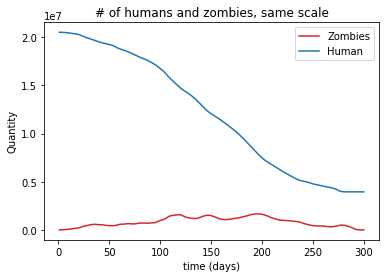

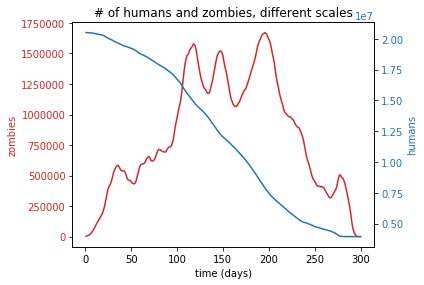

In [73]:
# Hist: 
"""
 ------   D-249 Z=465223 H=4808677   ------ 
 ------   D-250 Z=453880 H=4772926   ------ 
BREST HAS BEEN TAKEN
BREST HAS BEEN TAKEN
BREST HAS BEEN TAKEN
 ------   D-251 Z=440894 H=4745448   ------ 
 ------   D-252 Z=424940 H=4723216   ------ 

hist300days = {'h': [20505639, 20502897, 20499859, 20496006, 20490691, 20483187, 20474987, 20465073, 20452886, 20438337, 20422698, 20408166, 20393366, 20380696, 20366479, 20353205, 20335449, 20319877, 20299287, 20268559, 20235614, 20191345, 20143005, 20088653, 20044366, 20009048, 19979649, 19950219, 19912423, 19866938, 19822832, 19786557, 19752928, 19720081, 19683749, 19648524, 19617838, 19581071, 19541185, 19502766, 19466937, 19435127, 19410963, 19391485, 19370262, 19347861, 19319203, 19289166, 19257846, 19230681, 19204911, 19182811, 19147564, 19106710, 19056618, 18994810, 18932536, 18878398, 18831239, 18790026, 18756944, 18724936, 18692955, 18659654, 18625138, 18584891, 18542568, 18499304, 18450335, 18404264, 18357169, 18309860, 18259435, 18210430, 18163591, 18118084, 18065509, 18010120, 17957256, 17912787, 17870808, 17831623, 17793594, 17751537, 17707267, 17662936, 17617096, 17562126, 17498775, 17439396, 17386534, 17330716, 17274303, 17214135, 17146749, 17076703, 16987400, 16899436, 16821344, 16740312, 16656978, 16571697, 16484583, 16387547, 16273632, 16152286, 16026230, 15905826, 15791998, 15690264, 15589645, 15493969, 15390229, 15289728, 15195468, 15105032, 15006821, 14903898, 14809558, 14714467, 14622669, 14547637, 14477359, 14407787, 14344972, 14285449, 14214137, 14137443, 14062116, 13982013, 13899385, 13812150, 13724653, 13633822, 13536033, 13424502, 13317117, 13213036, 13116363, 13010630, 12906489, 12795786, 12681643, 12574324, 12476037, 12381312, 12287203, 12203874, 12124070, 12049613, 11980573, 11914098, 11842405, 11775334, 11711953, 11648158, 11584862, 11517842, 11443800, 11364065, 11291052, 11213530, 11135324, 11057995, 10981185, 10901650, 10821542, 10739676, 10652930, 10567427, 10487686, 10406465, 10327771, 10240201, 10154611, 10057226, 9958831, 9857220, 9756554, 9650350, 9546980, 9442691, 9337630, 9223938, 9112348, 8998501, 8881816, 8765335, 8656843, 8549348, 8437987, 8318039, 8204186, 8093146, 7986283, 7875504, 7777539, 7680028, 7588232, 7492582, 7395508, 7304339, 7229400, 7157792, 7083101, 7010470, 6944274, 6884354, 6818289, 6744708, 6674154, 6612367, 6545657, 6477047, 6407509, 6341962, 6277471, 6216163, 6150577, 6086167, 6023332, 5962930, 5902672, 5839541, 5775102, 5715306, 5657994, 5609848, 5557142, 5498070, 5440901, 5383154, 5323440, 5274458, 5227364, 5186900, 5148714, 5118728, 5097121, 5073636, 5051701, 5025492, 4998461, 4968180, 4940098, 4912245, 4882208, 4845290, 4808677, 4772926, 4745448, 4723216, 4704747, 4683049, 4661183, 4640633, 4618251, 4587412, 4562430, 4540198, 4524666, 4509407, 4487514, 4461085, 4441084, 4424400, 4406193, 4381804, 4350706, 4316707, 4281868, 4244726, 4202905, 4154596, 4100001, 4043049, 4007190, 3982221, 3969729, 3956863, 3948548, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746], 'z': [2414, 4969, 8007, 11860, 17175, 24679, 32879, 42672, 54859, 68044, 83650, 98182, 112960, 125630, 139348, 150617, 165202, 177435, 193088, 217481, 242792, 278488, 316881, 358785, 389678, 409383, 424137, 438787, 463493, 494412, 525209, 544323, 562546, 575797, 581384, 583464, 570236, 558680, 544034, 537994, 538525, 540839, 535641, 517764, 493932, 472373, 464780, 461311, 459827, 451563, 442438, 433872, 432550, 434015, 445807, 471806, 502327, 532301, 559983, 579974, 590655, 594005, 595949, 597930, 605281, 619758, 639875, 647894, 655905, 651995, 637291, 622456, 618743, 620589, 626204, 638552, 659075, 681812, 701377, 711337, 713075, 710017, 704785, 697973, 696172, 693408, 691785, 696330, 710677, 723237, 730665, 734007, 735641, 742945, 765862, 793931, 844069, 894004, 930039, 966813, 1005818, 1044992, 1077136, 1110821, 1165357, 1233841, 1303738, 1367641, 1420531, 1454879, 1484836, 1490923, 1506701, 1529044, 1542272, 1549409, 1562676, 1578441, 1575745, 1556921, 1527405, 1476717, 1426656, 1383100, 1344237, 1303696, 1279487, 1252294, 1226774, 1212596, 1204165, 1193165, 1176856, 1172225, 1174859, 1193962, 1225937, 1259650, 1286756, 1329419, 1373978, 1413246, 1450856, 1483227, 1501210, 1513888, 1520884, 1517647, 1507684, 1484439, 1442557, 1402005, 1369758, 1339627, 1297444, 1257202, 1210029, 1162909, 1129261, 1110938, 1089227, 1072640, 1067527, 1065052, 1067405, 1077900, 1091533, 1101756, 1121938, 1144130, 1160076, 1178020, 1189710, 1203589, 1209454, 1233826, 1254699, 1278104, 1301441, 1330835, 1354670, 1378851, 1402046, 1428992, 1455079, 1489185, 1524649, 1562436, 1583358, 1605263, 1619239, 1640792, 1653034, 1663408, 1663528, 1670937, 1664613, 1657063, 1635167, 1619227, 1602454, 1576938, 1535396, 1498512, 1465708, 1426978, 1373226, 1319324, 1274367, 1241575, 1201350, 1165172, 1134371, 1111185, 1085073, 1053546, 1026868, 1013237, 1007215, 996934, 987138, 981344, 981682, 978748, 969375, 958617, 954142, 935578, 919520, 909054, 900676, 893932, 892338, 875734, 858418, 836047, 813831, 783567, 742056, 701312, 663361, 632170, 611019, 588734, 557579, 528175, 500465, 477669, 465223, 453880, 440894, 424940, 413423, 413514, 411932, 410569, 406825, 410677, 405339, 399644, 387403, 372387, 357365, 347251, 331501, 320707, 316682, 322602, 332002, 344140, 358470, 373231, 384219, 407598, 439965, 481397, 502217, 505293, 491356, 484221, 475852, 458447, 434058, 402960, 368961, 334122, 296980, 255159, 206850, 152255, 95303, 59444, 34475, 21983, 9117, 802, 0, 0, 0, 0], 'b': 250}
"""

hist300days = {'h': [20505639, 20502897, 20499859, 20496006, 20490691, 20483187, 20474987, 20465073, 20452886, 20438337, 20422698, 20408166, 20393366, 20380696, 20366479, 20353205, 20335449, 20319877, 20299287, 20268559, 20235614, 20191345, 20143005, 20088653, 20044366, 20009048, 19979649, 19950219, 19912423, 19866938, 19822832, 19786557, 19752928, 19720081, 19683749, 19648524, 19617838, 19581071, 19541185, 19502766, 19466937, 19435127, 19410963, 19391485, 19370262, 19347861, 19319203, 19289166, 19257846, 19230681, 19204911, 19182811, 19147564, 19106710, 19056618, 18994810, 18932536, 18878398, 18831239, 18790026, 18756944, 18724936, 18692955, 18659654, 18625138, 18584891, 18542568, 18499304, 18450335, 18404264, 18357169, 18309860, 18259435, 18210430, 18163591, 18118084, 18065509, 18010120, 17957256, 17912787, 17870808, 17831623, 17793594, 17751537, 17707267, 17662936, 17617096, 17562126, 17498775, 17439396, 17386534, 17330716, 17274303, 17214135, 17146749, 17076703, 16987400, 16899436, 16821344, 16740312, 16656978, 16571697, 16484583, 16387547, 16273632, 16152286, 16026230, 15905826, 15791998, 15690264, 15589645, 15493969, 15390229, 15289728, 15195468, 15105032, 15006821, 14903898, 14809558, 14714467, 14622669, 14547637, 14477359, 14407787, 14344972, 14285449, 14214137, 14137443, 14062116, 13982013, 13899385, 13812150, 13724653, 13633822, 13536033, 13424502, 13317117, 13213036, 13116363, 13010630, 12906489, 12795786, 12681643, 12574324, 12476037, 12381312, 12287203, 12203874, 12124070, 12049613, 11980573, 11914098, 11842405, 11775334, 11711953, 11648158, 11584862, 11517842, 11443800, 11364065, 11291052, 11213530, 11135324, 11057995, 10981185, 10901650, 10821542, 10739676, 10652930, 10567427, 10487686, 10406465, 10327771, 10240201, 10154611, 10057226, 9958831, 9857220, 9756554, 9650350, 9546980, 9442691, 9337630, 9223938, 9112348, 8998501, 8881816, 8765335, 8656843, 8549348, 8437987, 8318039, 8204186, 8093146, 7986283, 7875504, 7777539, 7680028, 7588232, 7492582, 7395508, 7304339, 7229400, 7157792, 7083101, 7010470, 6944274, 6884354, 6818289, 6744708, 6674154, 6612367, 6545657, 6477047, 6407509, 6341962, 6277471, 6216163, 6150577, 6086167, 6023332, 5962930, 5902672, 5839541, 5775102, 5715306, 5657994, 5609848, 5557142, 5498070, 5440901, 5383154, 5323440, 5274458, 5227364, 5186900, 5148714, 5118728, 5097121, 5073636, 5051701, 5025492, 4998461, 4968180, 4940098, 4912245, 4882208, 4845290, 4808677, 4772926, 4745448, 4723216, 4704747, 4683049, 4661183, 4640633, 4618251, 4587412, 4562430, 4540198, 4524666, 4509407, 4487514, 4461085, 4441084, 4424400, 4406193, 4381804, 4350706, 4316707, 4281868, 4244726, 4202905, 4154596, 4100001, 4043049, 4007190, 3982221, 3969729, 3956863, 3948548, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746, 3947746], 'z': [2414, 4969, 8007, 11860, 17175, 24679, 32879, 42672, 54859, 68044, 83650, 98182, 112960, 125630, 139348, 150617, 165202, 177435, 193088, 217481, 242792, 278488, 316881, 358785, 389678, 409383, 424137, 438787, 463493, 494412, 525209, 544323, 562546, 575797, 581384, 583464, 570236, 558680, 544034, 537994, 538525, 540839, 535641, 517764, 493932, 472373, 464780, 461311, 459827, 451563, 442438, 433872, 432550, 434015, 445807, 471806, 502327, 532301, 559983, 579974, 590655, 594005, 595949, 597930, 605281, 619758, 639875, 647894, 655905, 651995, 637291, 622456, 618743, 620589, 626204, 638552, 659075, 681812, 701377, 711337, 713075, 710017, 704785, 697973, 696172, 693408, 691785, 696330, 710677, 723237, 730665, 734007, 735641, 742945, 765862, 793931, 844069, 894004, 930039, 966813, 1005818, 1044992, 1077136, 1110821, 1165357, 1233841, 1303738, 1367641, 1420531, 1454879, 1484836, 1490923, 1506701, 1529044, 1542272, 1549409, 1562676, 1578441, 1575745, 1556921, 1527405, 1476717, 1426656, 1383100, 1344237, 1303696, 1279487, 1252294, 1226774, 1212596, 1204165, 1193165, 1176856, 1172225, 1174859, 1193962, 1225937, 1259650, 1286756, 1329419, 1373978, 1413246, 1450856, 1483227, 1501210, 1513888, 1520884, 1517647, 1507684, 1484439, 1442557, 1402005, 1369758, 1339627, 1297444, 1257202, 1210029, 1162909, 1129261, 1110938, 1089227, 1072640, 1067527, 1065052, 1067405, 1077900, 1091533, 1101756, 1121938, 1144130, 1160076, 1178020, 1189710, 1203589, 1209454, 1233826, 1254699, 1278104, 1301441, 1330835, 1354670, 1378851, 1402046, 1428992, 1455079, 1489185, 1524649, 1562436, 1583358, 1605263, 1619239, 1640792, 1653034, 1663408, 1663528, 1670937, 1664613, 1657063, 1635167, 1619227, 1602454, 1576938, 1535396, 1498512, 1465708, 1426978, 1373226, 1319324, 1274367, 1241575, 1201350, 1165172, 1134371, 1111185, 1085073, 1053546, 1026868, 1013237, 1007215, 996934, 987138, 981344, 981682, 978748, 969375, 958617, 954142, 935578, 919520, 909054, 900676, 893932, 892338, 875734, 858418, 836047, 813831, 783567, 742056, 701312, 663361, 632170, 611019, 588734, 557579, 528175, 500465, 477669, 465223, 453880, 440894, 424940, 413423, 413514, 411932, 410569, 406825, 410677, 405339, 399644, 387403, 372387, 357365, 347251, 331501, 320707, 316682, 322602, 332002, 344140, 358470, 373231, 384219, 407598, 439965, 481397, 502217, 505293, 491356, 484221, 475852, 458447, 434058, 402960, 368961, 334122, 296980, 255159, 206850, 152255, 95303, 59444, 34475, 21983, 9117, 802, 0, 0, 0, 0], 'b': 250}
plotEvolution(hist300days, "ev_free")

In [367]:
def toGraph(grid):
    G = nx.Graph()
    for lon in range(len(grid)):
        for lat in range(len(grid[lon])):
            
            # concentrate in the half roght low corner of the image
            if not (lon > 234 / 2 and lat > 322 / 2): continue
            
            neighbor_cells = getNeigborCellList(lon, lat, grid) # just study possible moves
            for n in neighbor_cells:
                # check suitability
                geo_slope_fact = getGeoSlopeFactor(grid[lon][lat], n) # (from, to)
                if geo_slope_fact == 0 : continue # slope will not let pass zombies
                z0 = sum(n['z_0'])
                z1 = sum(n['z_1'])
                if n['hum'] == 0 and z0 + z1 == 0 : continue # We don't want to study where zombies will not pass through
                if n['valid'] == 0: continue
    
                G.add_edge(f'{lon}_{lat}', f'{n["i"]}_{n["j"]}') #weight = ?
    return G

In [380]:
G = toGraph(grid)
print(len(G.nodes))
print(len(G.edges))
# get all the graphs
g_a = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print(g_a)
graphs = list(nx.connected_component_subgraphs(G))

4374
13407
[3526, 197, 149, 105, 98, 42, 34, 21, 21, 19, 15, 15, 15, 15, 15, 12, 12, 12, 9, 9, 9, 9, 9, 6]


In [211]:
len_graph = []
for g in graphs:
    len_graph.append(len(g))
print(len_graph)
GG = graphs[0]
print(len(GG))
cutsets = list(nx.all_node_cuts(GG))

[3025, 149, 15, 9, 15, 21, 105, 98, 21, 9, 15, 15, 19, 42, 35, 9, 9]
3025


KeyboardInterrupt: 

In [340]:
ct = nx.minimum_edge_cut(graphs[0], s='163_235', t='130_200')

In [341]:
print(ct)

{('130_201', '130_200'), ('129_199', '130_200'), ('129_201', '130_200'), ('129_200', '130_200'), ('131_200', '130_200'), ('130_199', '130_200'), ('131_201', '130_200'), ('131_199', '130_200')}


In [342]:
graphs[0].edges

EdgeView([('118_162', '117_161'), ('118_162', '117_162'), ('118_162', '117_163'), ('118_162', '118_161'), ('118_162', '118_163'), ('118_162', '119_161'), ('118_162', '119_162'), ('118_162', '119_163'), ('117_162', '118_163'), ('117_163', '118_163'), ('117_163', '118_164'), ('118_161', '119_162'), ('118_163', '117_164'), ('118_163', '118_164'), ('118_163', '119_162'), ('118_163', '119_163'), ('118_163', '119_164'), ('119_161', '119_162'), ('119_161', '120_162'), ('119_162', '119_163'), ('119_162', '120_161'), ('119_162', '120_162'), ('119_162', '120_163'), ('119_163', '118_164'), ('119_163', '119_164'), ('119_163', '120_162'), ('119_163', '120_163'), ('119_163', '120_164'), ('117_164', '118_164'), ('117_164', '118_165'), ('118_164', '117_165'), ('118_164', '118_165'), ('118_164', '119_164'), ('118_164', '119_165'), ('119_164', '118_165'), ('119_164', '119_165'), ('119_164', '120_163'), ('119_164', '120_164'), ('119_164', '120_165'), ('117_165', '118_165'), ('117_165', '118_166'), ('118_

In [369]:
nc = nx.minimum_node_cut(graphs[0], s='142_229', t='118_170')

In [370]:
print(nc)

{'143_230'}


In [223]:
kc = nx.k_components(graphs[0])

KeyboardInterrupt: 

In [381]:
v = nx.betweenness_centrality(graphs[0])

In [382]:
vv = [{'n': k, 'v': val} for k, val in v.items()]

In [383]:
vv =sorted(vv, key=itemgetter('v'), reverse=True)
vv

[{'n': '142_214', 'v': 0.22550979795666676},
 {'n': '143_215', 'v': 0.20127001354928822},
 {'n': '147_195', 'v': 0.1930873733112877},
 {'n': '141_213', 'v': 0.19096245059285277},
 {'n': '145_197', 'v': 0.18067123643323654},
 {'n': '146_196', 'v': 0.17812555900372276},
 {'n': '144_216', 'v': 0.16237562618576998},
 {'n': '140_212', 'v': 0.1322384662924368},
 {'n': '140_208', 'v': 0.131689822576972},
 {'n': '144_198', 'v': 0.1296188307121733},
 {'n': '145_217', 'v': 0.12750599295590614},
 {'n': '141_212', 'v': 0.12459492299706369},
 {'n': '140_211', 'v': 0.12322782605696725},
 {'n': '140_210', 'v': 0.11336814094552301},
 {'n': '140_209', 'v': 0.11093369580110779},
 {'n': '139_209', 'v': 0.0991771648296013},
 {'n': '146_218', 'v': 0.09599522841639356},
 {'n': '143_199', 'v': 0.09214358862080557},
 {'n': '139_210', 'v': 0.09199416622355705},
 {'n': '140_207', 'v': 0.09150276386557385},
 {'n': '141_204', 'v': 0.08978727797777117},
 {'n': '139_208', 'v': 0.08943641531552848},
 {'n': '139_211'

In [384]:
l = []
for i in range(20):
    [lon, lat] = vv[i]['n'].split('_')
    l.append((int(lon), int(lat)))
l

[(142, 214),
 (143, 215),
 (147, 195),
 (141, 213),
 (145, 197),
 (146, 196),
 (144, 216),
 (140, 212),
 (140, 208),
 (144, 198),
 (145, 217),
 (141, 212),
 (140, 211),
 (140, 210),
 (140, 209),
 (139, 209),
 (146, 218),
 (143, 199),
 (139, 210),
 (140, 207)]

In [375]:
from networkx.algorithms.flow import shortest_augmenting_path, maximum_flow

In [376]:
nx.node_connectivity(graphs[0], flow_func=shortest_augmenting_path)

1

In [182]:
s = grid_state[0]['state']
lons = []
lats = []
sub_lats = []
sub_lons = []
temp_lon = 0
temp_lat = 0
for k, v in s.items():
    [lon, lat] = k.split('_')
    lon = int(lon)
    lat = int(lat)
    if (len(sub_lats) > 0 and sub_lats[-1] + 2 <= lat) or (len(sub_lons) > 0 and sub_lons[-1] + 2 <= lon):
        lons.append(sub_lons)
        lats.append(sub_lats)
        sub_lons = []
        sub_lats = []
    
    if lon not in sub_lons: sub_lons.append(lon)
    if lat not in sub_lats: sub_lats.append(lat)


In [184]:
print(len(lats))
print(len(lons))
print(s)
print(lons)
print('---')
print(lats)

205
205
{'82_260': 1120, '82_261': 1637, '82_262': 2735, '82_263': 3017, '82_264': 6675, '82_265': 7663, '82_266': 3755, '82_267': 9302, '82_268': 8574, '82_269': 13277, '82_270': 8130, '82_271': 9101, '82_272': 3281, '82_273': 1426, '82_274': 7080, '82_275': 12469, '82_276': 9847, '82_277': 610, '82_278': 6907, '82_279': 6112, '82_284': 2681, '82_285': 1071, '82_286': 507, '82_289': 20, '82_290': 121, '82_291': 1871, '82_292': 399, '82_293': 1969, '82_294': 3305, '82_295': 1512, '82_296': 462, '82_297': 7785, '82_298': 5049, '82_299': 377, '82_300': 94, '83_260': 1364, '83_263': 12, '83_265': 5, '83_266': 7, '83_268': 38, '83_269': 64, '83_272': 1, '83_273': 21, '83_274': 27, '83_278': 4, '83_279': 4, '83_281': 1117, '83_282': 2589, '83_284': 5, '83_285': 10, '83_291': 5, '83_292': 7, '83_293': 4, '83_297': 26, '83_298': 21, '83_301': 260, '84_260': 4147, '84_261': 8, '84_266': 2, '84_267': 9, '84_268': 8, '84_269': 8, '84_270': 125, '84_272': 7, '84_274': 12, '84_275': 87, '84_276': 

In [ ]:
subgrid = [[grid[z_loc[0] - 2 + j][z_loc[1] - 2 + i] for i in range(5)] for j in range(5)]

In [191]:
print(grid_state[0]['mx'])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [309]:
def getZombiesGraph(st, grid):
    G = nx.Graph()
    for lon in range(len(grid)):
        for lat in range(len(grid[lon])):
            
            # concentrate in the half roght low corner of the image
            if not (lon > 234 / 2 and lat > 322 / 2): continue
            if not f'{lon}_{lat}' in st: continue
            neighbor_cells = getNeigborCellList(lon, lat, grid) # just study possible moves
            for n in neighbor_cells:
                # check suitability
                z0 = sum(n['z_0'])
                z1 = sum(n['z_1'])
                if z0 == 0 and z1 == 0 : continue # We don't want to study where zombies will not pass through
    
                G.add_edge(f'{lon}_{lat}', f'{n["i"]}_{n["j"]}') 
                           
    return G

In [359]:
zg = getZombiesGraph(grid_state[0]['state'], grid)

In [360]:
print(len(grid_state[0]['state']))
print(len(zg.nodes))

607
312


In [361]:
z_g = [len(c) for c in sorted(nx.connected_components(zg), key=len, reverse=True)]
print(z_g)
zgraphs = [c for c in sorted(list(nx.connected_component_subgraphs(zg)), key=len, reverse=True)] 


[216, 69, 6, 6, 5, 2, 2, 2, 2, 2]


In [362]:
zgraphs[0].nodes

NodeView(('137_244', '138_243', '139_243', '139_244', '139_235', '139_236', '140_235', '140_236', '139_237', '140_237', '140_238', '140_242', '141_235', '141_237', '141_238', '140_241', '141_241', '141_242', '141_243', '142_235', '142_236', '142_237', '142_238', '142_239', '142_240', '142_242', '142_243', '142_244', '143_235', '143_238', '143_242', '143_244', '142_245', '142_246', '143_247', '142_248', '144_235', '144_237', '144_238', '145_235', '145_236', '145_237', '146_235', '146_237', '147_235', '147_237', '147_238', '148_235', '148_237', '148_238', '149_235', '149_237', '149_238', '150_235', '150_237', '150_238', '150_239', '149_240', '149_241', '150_241', '151_235', '151_238', '151_239', '152_235', '152_236', '152_238', '153_235', '153_236', '153_238', '154_235', '154_236', '154_238', '153_244', '153_245', '154_244', '154_245', '153_246', '155_235', '155_236', '155_238', '155_239', '155_244', '155_245', '155_246', '156_235', '156_238', '156_239', '156_240', '156_243', '157_235', 

In [363]:
zgraphs[1].nodes

NodeView(('191_280', '193_280', '200_281', '194_280', '198_287', '193_283', '197_284', '195_282', '192_286', '195_279', '197_285', '190_281', '190_287', '189_281', '186_284', '196_284', '200_282', '198_284', '195_281', '196_283', '190_280', '192_283', '197_281', '198_285', '200_279', '190_284', '196_279', '186_283', '190_283', '194_283', '192_282', '190_289', '195_280', '188_281', '199_279', '200_285', '191_285', '193_287', '189_285', '194_282', '192_280', '196_281', '200_283', '200_280', '193_286', '194_279', '197_286', '199_278', '199_280', '200_286', '191_281', '199_288', '194_287', '197_283', '198_281', '194_285', '199_281', '197_279', '188_284', '192_289', '198_279', '191_286', '200_284', '191_284', '200_278', '192_281', '198_280', '187_284', '191_288'))

In [377]:
col = []
for node in zgraphs[0].nodes:
    nc = nx.minimum_node_cut(graphs[0], s=node, t='132_206')
    print(nc)

{'142_239', '142_240'}
{'142_239', '142_240'}
{'142_239', '142_240'}
{'142_239', '142_240'}
{'140_236', '140_234', '139_234', '140_238', '140_235', '140_237', '139_233'}
{'140_236', '139_234', '139_235', '140_238', '140_235', '140_237'}
{'131_207', '131_205', '132_205', '132_207', '133_206', '131_206', '133_205', '133_207'}
{'131_207', '131_205', '132_205', '132_207', '133_206', '131_206', '133_205', '133_207'}
{'140_236', '139_235', '140_238', '139_236', '140_237'}
{'140_236', '141_238', '141_236', '141_239', '139_235', '141_237', '139_236'}
{'141_238', '141_239', '141_237', '140_237', '139_237'}
{'142_239', '142_240'}
{'131_207', '131_205', '132_205', '132_207', '133_206', '131_206', '133_205', '133_207'}
{'131_207', '131_205', '132_205', '132_207', '133_206', '131_206', '133_205', '133_207'}
{'144_237', '144_238', '142_237', '141_237', '140_237', '142_236', '139_237'}
{'142_239', '142_240'}
{'142_239', '142_240'}
{'142_239', '142_240'}
{'142_239', '142_240'}
{'131_207', '131_205', '

KeyboardInterrupt: 

In [25]:
def pointsToProtect(grid, pts):
    for p in pts:
        grid[p[0]][p[1]]['valid'] = 1

In [29]:
ngrid = initializeGrid(vld_img_grid_arr, 
               pop_img_grid_arr,
               elv_img_grid_arr,
               pop_vals,
               elv_vals
              )
pnts = [(142, 214),
 (143, 215),
 (147, 195),
 (141, 213),
 (145, 197),
 (146, 196),
 (144, 216),
 (140, 212),
 (140, 208),
 (144, 198),
 (145, 217),
 (141, 212),
 (140, 211),
 (140, 210),
 (140, 209),
 (139, 209),
 (146, 218),
 (143, 199),
 (139, 210),
 (140, 207)]
initializeZombies(ngrid, z_loc[0], z_loc[1], rize_p)
#pointsToProtect(ngrid, pnts)
#grid_state = []
G = nx.Graph()
run(ngrid, 96, True, G, 59, 96)

 ------   D-1 Z=2414 H=20505639   ------ 
 ------   D-2 Z=4969 H=20502897   ------ 
 ------   D-3 Z=8007 H=20499859   ------ 
 ------   D-4 Z=11860 H=20496006   ------ 
 ------   D-5 Z=17175 H=20490691   ------ 
 ------   D-6 Z=24679 H=20483187   ------ 
 ------   D-7 Z=32879 H=20474987   ------ 
 ------   D-8 Z=42672 H=20465073   ------ 
 ------   D-9 Z=54859 H=20452886   ------ 
 ------   D-10 Z=68042 H=20438317   ------ 
 ------   D-11 Z=83628 H=20422698   ------ 
 ------   D-12 Z=98160 H=20408166   ------ 
 ------   D-13 Z=112966 H=20393360   ------ 
 ------   D-14 Z=125710 H=20380606   ------ 
 ------   D-15 Z=139401 H=20366403   ------ 
 ------   D-16 Z=150567 H=20353163   ------ 
 ------   D-17 Z=165187 H=20335790   ------ 
 ------   D-18 Z=177569 H=20319891   ------ 
 ------   D-19 Z=193594 H=20299077   ------ 
 ------   D-20 Z=218007 H=20268326   ------ 
 ------   D-21 Z=243162 H=20235536   ------ 
 ------   D-22 Z=278842 H=20191270   ------ 
 ------   D-23 Z=317170 H=20142995

In [30]:
len(G.edges)

24444

In [31]:
gg = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print(gg)
ggs = [c for c in sorted(list(nx.connected_component_subgraphs(G)), key=len, reverse=True)] 

[4919, 1732, 159, 34, 34, 12, 12, 12, 9, 9, 9, 9, 6, 6]


In [34]:
nx.radius(ggs[1])

35

In [450]:
b = nx.betweenness_centrality(ggs[1], weight='weight')

In [451]:
bb = [{'n': k, 'v': val} for k, val in b.items()]
bb =sorted(bb, key=itemgetter('v'), reverse=True)
bb

[{'n': '125_212', 'v': 0.5833355086176204},
 {'n': '143_223', 'v': 0.5763918033931723},
 {'n': '124_211', 'v': 0.5706395324528657},
 {'n': '123_210', 'v': 0.5625848219623005},
 {'n': '122_209', 'v': 0.5483147874809371},
 {'n': '121_208', 'v': 0.5214873452694835},
 {'n': '144_224', 'v': 0.48938917508473434},
 {'n': '129_216', 'v': 0.48811118143588256},
 {'n': '131_218', 'v': 0.48670196446816816},
 {'n': '172_234', 'v': 0.4836080321892355},
 {'n': '172_227', 'v': 0.46821456224578833},
 {'n': '126_213', 'v': 0.4674626625163342},
 {'n': '130_217', 'v': 0.4126914334931396},
 {'n': '128_215', 'v': 0.40740266761045607},
 {'n': '143_222', 'v': 0.37485575322580533},
 {'n': '119_206', 'v': 0.34713438217066783},
 {'n': '173_235', 'v': 0.3434613157611043},
 {'n': '165_225', 'v': 0.33612591811122494},
 {'n': '170_226', 'v': 0.32824268782421623},
 {'n': '120_207', 'v': 0.32754072075700513},
 {'n': '132_220', 'v': 0.317693680533563},
 {'n': '145_224', 'v': 0.3126419584881175},
 {'n': '172_228', 'v': 

In [452]:
l = []
for i in range(20):
    [lon, lat] = bb[i]['n'].split('_')
    l.append((int(lon), int(lat)))
l

[(125, 212),
 (143, 223),
 (124, 211),
 (123, 210),
 (122, 209),
 (121, 208),
 (144, 224),
 (129, 216),
 (131, 218),
 (172, 234),
 (172, 227),
 (126, 213),
 (130, 217),
 (128, 215),
 (143, 222),
 (119, 206),
 (173, 235),
 (165, 225),
 (170, 226),
 (120, 207)]

In [453]:
nx.minimum_node_cut(G, s='165_234', t='128_214')

{'139_230', '140_230', '142_221', '144_217', '144_218'}

In [28]:
ngrid = initializeGrid(vld_img_grid_arr, 
               pop_img_grid_arr,
               elv_img_grid_arr,
               pop_vals,
               elv_vals
              )
pnts = [(125, 212),
 (143, 223),
 (124, 211),
 (123, 210),
 (122, 209),
 (121, 208),
 (144, 224),
 (129, 216),
 (131, 218),
 (172, 234),
 (172, 227),
 (126, 213),
 (130, 217),
 (128, 215),
 (143, 222),
 (119, 206),
 (173, 235),
 (165, 225),
 (170, 226),
 (120, 207)]
initializeZombies(ngrid, z_loc[0], z_loc[1], rize_p)
pointsToProtect(ngrid, pnts)
grid_state = []
run(ngrid, 100, True)

 ------   D-1 Z=2414 H=20505639   ------ 
 ------   D-2 Z=4969 H=20502897   ------ 
 ------   D-3 Z=8007 H=20499859   ------ 
 ------   D-4 Z=11860 H=20496006   ------ 
 ------   D-5 Z=17175 H=20490691   ------ 
 ------   D-6 Z=24679 H=20483187   ------ 
 ------   D-7 Z=32879 H=20474987   ------ 
 ------   D-8 Z=42674 H=20465093   ------ 
 ------   D-9 Z=54881 H=20452886   ------ 
 ------   D-10 Z=68064 H=20438317   ------ 
 ------   D-11 Z=83629 H=20422708   ------ 
 ------   D-12 Z=98181 H=20408156   ------ 
 ------   D-13 Z=112977 H=20393360   ------ 
 ------   D-14 Z=125721 H=20380606   ------ 
 ------   D-15 Z=139516 H=20366394   ------ 
 ------   D-16 Z=150625 H=20353162   ------ 
 ------   D-17 Z=165268 H=20335793   ------ 
 ------   D-18 Z=177831 H=20319880   ------ 
 ------   D-19 Z=193719 H=20299387   ------ 
 ------   D-20 Z=218208 H=20268549   ------ 
 ------   D-21 Z=243508 H=20235624   ------ 
 ------   D-22 Z=279208 H=20191315   ------ 
 ------   D-23 Z=317564 H=20142978

In [26]:
grid = initializeGrid(vld_img_grid_arr, 
               pop_img_grid_arr,
               elv_img_grid_arr,
               pop_vals,
               elv_vals
              )
pts = [(199,9), (197,8)] + [(200,i) for i in range(9,131)] + [(i,130) for i in range(200,221)]
sum_h = 0
for p in pts:
    (lon, lat) = p
    sum_h += grid[lon][lat]['hum']
sum_h

8418